In [53]:
# !pip install pandas numpy matplotlib seaborn opencv-python scikit-learn tqdm segmentation_models_pytorch

/Users/andretakeoloschnerfujiwara/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road


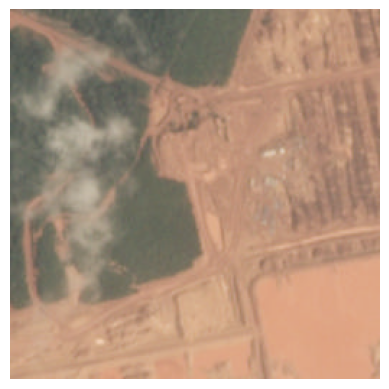

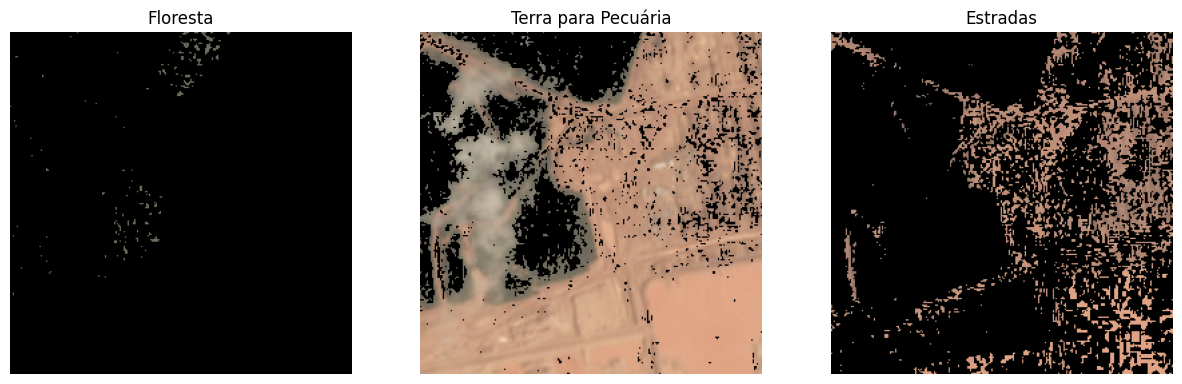

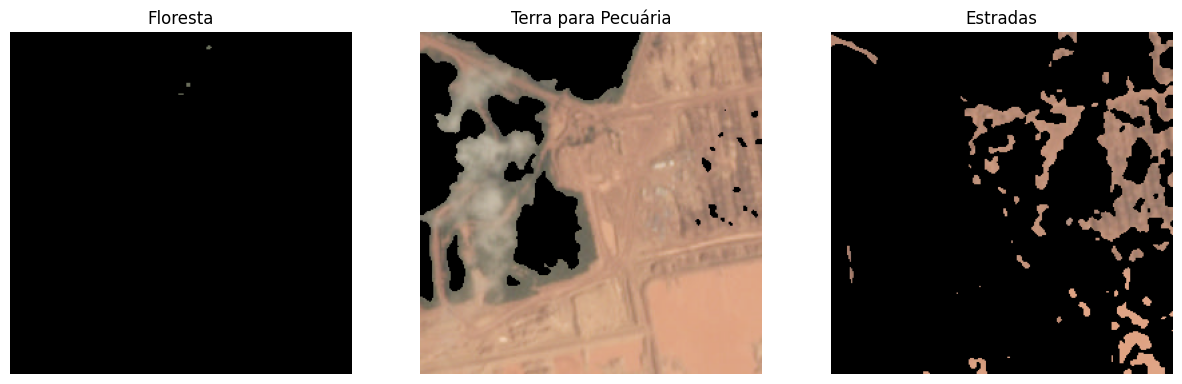

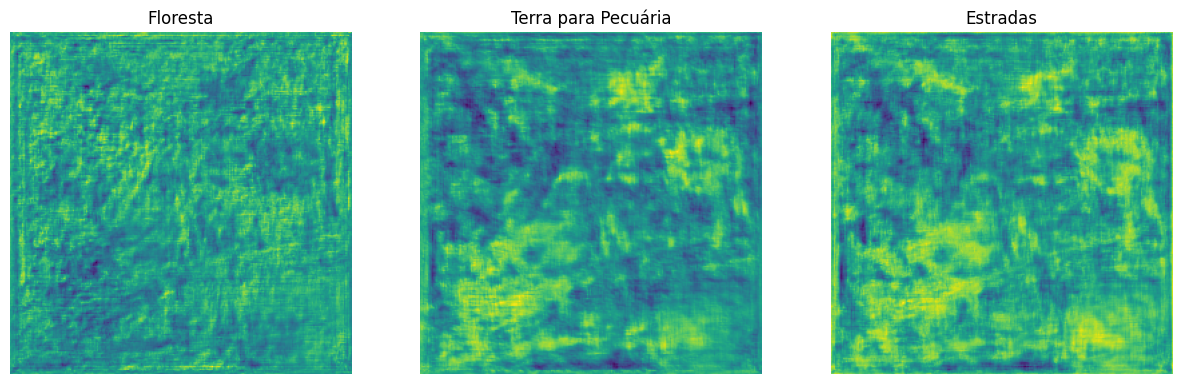

In [1]:
# Importando bibliotecas para manipulação de dados
import pandas as pd
import numpy as np

# Importando bibliotecas para visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Importando biblioteca para processamento de imagens
import cv2

# Importando biblioteca para exibir barra de progresso
from tqdm import tqdm

# Importando biblioteca para redução de dimensionalidade
from sklearn.manifold import TSNE

# Importando biblioteca para manipulação de arquivos
import pickle
import os

# Importando biblioteca de deep learning para segmentação
import segmentation_models_pytorch as smp
import torch
from torchvision import transforms
from PIL import Image

# Carregar os dados
df = pd.read_csv(r'planet/planet/train_classes.csv')
print(df.head())

# Função para mostrar uma imagem
def show_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Exemplo de visualização de imagem
image = r'planet/planet/train-jpg/train_24.jpg'
show_image(image)

# Função para segmentação de imagem ajustada
def adjust_segment_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Ajustar limites de cor para diferentes categorias
    lower_forest = np.array([35, 40, 40])
    upper_forest = np.array([85, 255, 255])
    
    lower_land = np.array([10, 0, 50])
    upper_land = np.array([25, 255, 255])
    
    lower_road = np.array([0, 0, 50])
    upper_road = np.array([10, 255, 255])
    
    # Criar máscaras
    mask_forest = cv2.inRange(hsv, lower_forest, upper_forest)
    mask_land = cv2.inRange(hsv, lower_land, upper_land)
    mask_road = cv2.inRange(hsv, lower_road, upper_road)
    
    # Aplicar máscaras
    forest_segment = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_forest)
    land_segment = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_land)
    road_segment = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_road)
    
    return forest_segment, land_segment, road_segment

# Exemplo de segmentação ajustada
forest_segment, land_segment, road_segment = adjust_segment_image(image)

# Mostrar segmentações ajustadas
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(forest_segment)
plt.axis('off')
plt.title('Floresta')

plt.subplot(1, 3, 2)
plt.imshow(land_segment)
plt.axis('off')
plt.title('Terra para Pecuária')

plt.subplot(1, 3, 3)
plt.imshow(road_segment)
plt.axis('off')
plt.title('Estradas')

plt.show()

# Função para segmentação de imagem com suavização
def smooth_segment_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Aplicar filtro de suavização para reduzir o ruído
    hsv_blurred = cv2.GaussianBlur(hsv, (11, 11), 0)
    
    # Ajustar limites de cor para diferentes categorias
    lower_forest = np.array([35, 40, 40])
    upper_forest = np.array([85, 255, 255])
    
    lower_land = np.array([10, 0, 50])
    upper_land = np.array([25, 255, 255])
    
    lower_road = np.array([0, 0, 50])
    upper_road = np.array([10, 255, 255])
    
    # Criar máscaras
    mask_forest = cv2.inRange(hsv_blurred, lower_forest, upper_forest)
    mask_land = cv2.inRange(hsv_blurred, lower_land, upper_land)
    mask_road = cv2.inRange(hsv_blurred, lower_road, upper_road)
    
    # Aplicar máscaras
    forest_segment = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_forest)
    land_segment = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_land)
    road_segment = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_road)
    
    return forest_segment, land_segment, road_segment

# Exemplo de segmentação com suavização
forest_segment, land_segment, road_segment = smooth_segment_image(image)

# Mostrar segmentações com suavização
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(forest_segment)
plt.axis('off')
plt.title('Floresta')

plt.subplot(1, 3, 2)
plt.imshow(land_segment)
plt.axis('off')
plt.title('Terra para Pecuária')

plt.subplot(1, 3, 3)
plt.imshow(road_segment)
plt.axis('off')
plt.title('Estradas')

plt.show()

# Carregar o modelo pré-treinado
model = smp.Unet('resnet34', encoder_weights='imagenet', classes=3, activation=None)
model.eval()

# Transformação da imagem
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def segment_image_deep_learning(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # Adicionar batch dimension
    
    with torch.no_grad():
        output = model(input_tensor)
        output = torch.sigmoid(output)
        output = output.squeeze().numpy()
    
    return output

# Exemplo de segmentação com deep learning
output = segment_image_deep_learning(image)

# Mostrar resultados
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(output[i])
    plt.axis('off')
    plt.title(['Floresta', 'Terra para Pecuária', 'Estradas'][i])

plt.show()
